### Fitting two input neurons' activity using van Rossum loss (Current-Based Model)

* We generate activity from a neuron driven by **two** feedforward excitatory cells (both at 6Hz)
* Then we try to recover both weights by optimising the van Rossum loss with tau=10ms
* This version uses the **feedforward current-based model**

In [1]:
import numpy as np
from network_inputs.supervised import CyclicSampler
from network_inputs.unsupervised import HomogeneousPoissonSpikeDataLoader
from network_simulators.feedforward_current_based.simulator import (
    FeedforwardCurrentLIFNetwork,
)
import torch
from torch.utils.data import DataLoader
from torch.amp import GradScaler
from optimisation.loss_functions import VanRossumLoss
import matplotlib.pyplot as plt
from tqdm import tqdm

### Define network parameters

In [2]:
# Postsynaptic neuron parameters
cell_params = [
    {
        "name": "excitatory",
        "cell_id": 0,
        "tau_mem": 100.0,  # Membrane time constant (ms)
        "tau_ref": 2.0,  # Refractory period (ms)
        "theta": -50.0,  # Threshold potential (mV) - kept for visualization
        "E_L": -70.0,  # Resting potential (mV) - kept for visualization
    }
]

# Feedforward synapse parameters (one excitatory synapse type)
synapse_params_FF = [
    {
        "name": "AMPA",
        "synapse_id": 0,
        "cell_id": 0,  # Presynaptic cell type that produces this synapse
        "tau_syn": 5.0,  # Synaptic time constant (ms)
        "type": "excitatory",  # Excitatory synapse
    }
]

# Hyperparameters
surrgrad_scale = 10.0  # Surrogate gradient scale
van_rossum_tau = (
    10.0  # Van Rossum loss time constant (ms) - shorter than single neuron case
)

### Create teacher network with two input neurons

In [3]:
# Define network with TWO inputs
dt = 1.0
teacher_weights = np.array([[0.1], [0.15]])  # Two inputs to one output neuron
cell_type_indices = np.array([0])  # Single output neuron
cell_type_indices_FF = np.array([0, 0])  # Two input neurons (both excitatory)
feedforward_mask = np.array([[True], [True]])  # Both inputs connect to output

teacher_model = FeedforwardCurrentLIFNetwork(
    dt=dt,
    weights_FF=teacher_weights,
    cell_type_indices=cell_type_indices,
    cell_type_indices_FF=cell_type_indices_FF,
    cell_params=cell_params,
    synapse_params_FF=synapse_params_FF,
    surrgrad_scale=surrgrad_scale,
    batch_size=1,
    optimisable=None,
    feedforward_mask=feedforward_mask,
    track_variables=False,
    use_tqdm=False,
)

print("Teacher network initialized with weights:")
print(f"  Input 1 -> Output: {teacher_weights[0, 0]:.3f}")
print(f"  Input 2 -> Output: {teacher_weights[1, 0]:.3f}")

Teacher network initialized with weights:
  Input 1 -> Output: 0.100
  Input 2 -> Output: 0.150


### Generate teacher activity with two 6Hz input neurons

In [4]:
# Create Poisson spike dataloader for teacher network
firing_rates = np.array([6.0, 6.0])  # Both inputs at 6 Hz
chunk_size = 1000.0  # 1 second chunks
n_chunks = 20  # Run for 20 seconds total

spike_dataloader = HomogeneousPoissonSpikeDataLoader(
    firing_rates=firing_rates, chunk_size=chunk_size, dt=dt, batch_size=1, device="cpu"
)

In [5]:
# Generate teacher activity by running the network with input spikes
teacher_model.reset_state()

all_input_spikes = []
all_output_spikes = []

with torch.no_grad():
    for chunk_idx, (input_spikes_chunk, _) in enumerate(spike_dataloader):
        if chunk_idx >= n_chunks:
            break

        # Run one chunk through the network
        output_spikes_chunk = teacher_model(input_spikes_chunk)

        # Accumulate results
        all_input_spikes.append(input_spikes_chunk)
        all_output_spikes.append(output_spikes_chunk)

# Concatenate all chunks along time dimension
input_spikes = torch.cat(all_input_spikes, dim=1)
output_spikes = torch.cat(all_output_spikes, dim=1)

print(f"Collected {input_spikes.shape[1]} timesteps of data")
print(f"Input spikes shape: {input_spikes.shape}")
print(f"Output spikes shape: {output_spikes.shape}")

Collected 20000 timesteps of data
Input spikes shape: torch.Size([1, 20000, 2])
Output spikes shape: torch.Size([1, 20000, 1])


### Visualize 3 spike trains: 2 inputs + 1 output

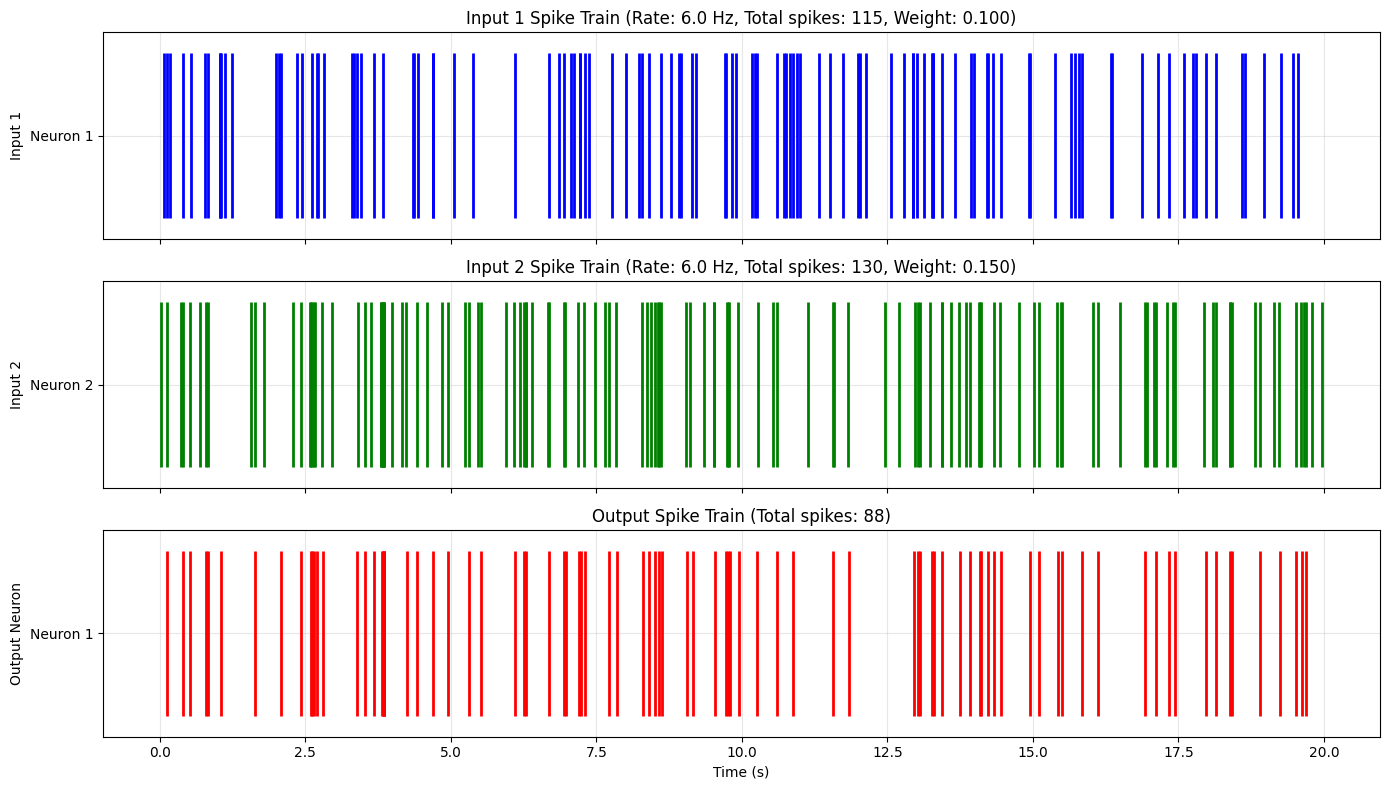


Input 1 spike count: 115
Input 2 spike count: 130
Output spike count: 88

Teacher weights:
  Weight 1: 0.100
  Weight 2: 0.150


In [6]:
# Visualize input and output spike trains
time_axis = np.arange(input_spikes.shape[1]) * dt / 1000.0  # Convert to seconds
input1_spike_indices = torch.where(input_spikes[0, :, 0])[0].numpy()
input2_spike_indices = torch.where(input_spikes[0, :, 1])[0].numpy()
output_spike_indices = torch.where(output_spikes[0, :, 0])[0].numpy()

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

# Plot input 1 spikes
ax1.eventplot(
    [input1_spike_indices * dt / 1000.0],
    lineoffsets=0.5,
    linelengths=0.8,
    color="blue",
    linewidths=2,
)
ax1.set_ylabel("Input 1")
ax1.set_title(
    f"Input 1 Spike Train (Rate: {firing_rates[0]} Hz, Total spikes: {len(input1_spike_indices)}, Weight: {teacher_weights[0, 0]:.3f})"
)
ax1.set_ylim([0, 1])
ax1.set_yticks([0.5])
ax1.set_yticklabels(["Neuron 1"])
ax1.grid(True, alpha=0.3)

# Plot input 2 spikes
ax2.eventplot(
    [input2_spike_indices * dt / 1000.0],
    lineoffsets=0.5,
    linelengths=0.8,
    color="green",
    linewidths=2,
)
ax2.set_ylabel("Input 2")
ax2.set_title(
    f"Input 2 Spike Train (Rate: {firing_rates[1]} Hz, Total spikes: {len(input2_spike_indices)}, Weight: {teacher_weights[1, 0]:.3f})"
)
ax2.set_ylim([0, 1])
ax2.set_yticks([0.5])
ax2.set_yticklabels(["Neuron 2"])
ax2.grid(True, alpha=0.3)

# Plot output spikes
ax3.eventplot(
    [output_spike_indices * dt / 1000.0],
    lineoffsets=0.5,
    linelengths=0.8,
    color="red",
    linewidths=2,
)
ax3.set_ylabel("Output Neuron")
ax3.set_title(f"Output Spike Train (Total spikes: {len(output_spike_indices)})")
ax3.set_xlabel("Time (s)")
ax3.set_ylim([0, 1])
ax3.set_yticks([0.5])
ax3.set_yticklabels(["Neuron 1"])
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nInput 1 spike count: {len(input1_spike_indices)}")
print(f"Input 2 spike count: {len(input2_spike_indices)}")
print(f"Output spike count: {len(output_spike_indices)}")
print("\nTeacher weights:")
print(f"  Weight 1: {teacher_model.weights_FF.data[0, 0].item():.3f}")
print(f"  Weight 2: {teacher_model.weights_FF.data[1, 0].item():.3f}")

### Setup Van Rossum loss with tau=10ms

In [7]:
# Initialize Van Rossum loss with tau=10ms
van_rossum_loss_fn = VanRossumLoss(
    tau=van_rossum_tau,
    dt=dt,
    window_size=100,  # Must be integer
    device="cpu",
)

print(f"Van Rossum loss initialized with tau={van_rossum_tau}ms")

Van Rossum loss initialized with tau=10.0ms


### Create student network with different weights to train

In [8]:
# Create student network with different weights to train
student_weights = np.array([[0.05], [0.25]])  # Different from teacher weights

student_model = FeedforwardCurrentLIFNetwork(
    dt=dt,
    weights_FF=student_weights,
    cell_type_indices=cell_type_indices,
    cell_type_indices_FF=cell_type_indices_FF,
    cell_params=cell_params,
    synapse_params_FF=synapse_params_FF,
    surrgrad_scale=surrgrad_scale,
    batch_size=1,
    optimisable="weights",  # Make weights trainable
    feedforward_mask=feedforward_mask,
    track_variables=False,
    use_tqdm=False,
)

# Setup optimizer
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.05)

# Setup learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-4
)

# Mixed precision scaler (disabled for CPU)
scaler = GradScaler("cpu", enabled=False)

print("Student network initialized with weights:")
print(f"  Weight 1: {student_weights[0, 0]:.3f} (target: {teacher_weights[0, 0]:.3f})")
print(f"  Weight 2: {student_weights[1, 0]:.3f} (target: {teacher_weights[1, 0]:.3f})")
print(f"Van Rossum loss tau: {van_rossum_tau}ms")

Student network initialized with weights:
  Weight 1: 0.050 (target: 0.100)
  Weight 2: 0.250 (target: 0.150)
Van Rossum loss tau: 10.0ms


### Create spike dataset for training

In [9]:
# Create PrecomputedSpikeDataset from our teacher data
class SimpleSpikeDataset(torch.utils.data.Dataset):
    def __init__(self, input_spikes, target_spikes, chunk_size_timesteps):
        """
        Args:
            input_spikes: Tensor of shape (batch, time, neurons)
            target_spikes: Tensor of shape (batch, time, neurons)
            chunk_size_timesteps: Number of timesteps per chunk
        """
        self.input_spikes = input_spikes
        self.target_spikes = target_spikes
        self.chunk_size = chunk_size_timesteps
        self.num_chunks = input_spikes.shape[1] // chunk_size_timesteps
        self.batch_size = input_spikes.shape[0]
        self.dt = dt

    def __len__(self):
        return self.num_chunks

    def __getitem__(self, idx):
        start_idx = idx * self.chunk_size
        end_idx = start_idx + self.chunk_size

        input_chunk = self.input_spikes[:, start_idx:end_idx, :]
        target_chunk = self.target_spikes[:, start_idx:end_idx, :]

        return input_chunk, target_chunk


# Create dataset from our teacher data
chunk_size_timesteps = int(chunk_size)
spike_dataset = SimpleSpikeDataset(
    input_spikes=input_spikes,
    target_spikes=output_spikes,
    chunk_size_timesteps=chunk_size_timesteps,
)

# Create cyclic sampler for training
spike_dataloader = DataLoader(
    spike_dataset,
    batch_size=None,  # Already batched
    sampler=CyclicSampler(spike_dataset),
    num_workers=0,
)

print(f"Created dataset with {spike_dataset.num_chunks} chunks")
print(f"Chunk size: {chunk_size_timesteps} timesteps ({chunk_size}ms)")

Created dataset with 20 chunks
Chunk size: 1000 timesteps (1000.0ms)


### Train student network to recover both weights

In [10]:
# Training parameters
chunk_size = 2000  # timesteps per chunk
n_chunks = 10  # chunks in the recording
epochs = 100  # times to loop through recording

print("Training configuration:")
print(f"  Chunk size: {chunk_size} timesteps")
print(f"  Chunks per epoch: {n_chunks}")
print(f"  Epochs: {epochs}")
print(f"  Total iterations: {epochs * n_chunks}")
print("\nInitial student weights:")
print(f"  Weight 1: {student_model.weights_FF.data[0, 0].item():.6f}")
print(f"  Weight 2: {student_model.weights_FF.data[1, 0].item():.6f}")
print("\nTarget teacher weights:")
print(f"  Weight 1: {teacher_model.weights_FF.data[0, 0].item():.6f}")
print(f"  Weight 2: {teacher_model.weights_FF.data[1, 0].item():.6f}")

Training configuration:
  Chunk size: 2000 timesteps
  Chunks per epoch: 10
  Epochs: 100
  Total iterations: 1000

Initial student weights:
  Weight 1: 0.050000
  Weight 2: 0.250000

Target teacher weights:
  Weight 1: 0.100000
  Weight 2: 0.150000


In [11]:
# Run training
# Reset student model with initial weights
student_model.weights_FF.data[0, 0] = student_weights[0, 0]
student_model.weights_FF.data[1, 0] = student_weights[1, 0]

# Ensure weights require gradients
student_model.weights_FF.requires_grad_(True)

# Reset optimizer and scheduler
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-4
)

# Track losses and weights (now 2 weights per epoch)
epoch_losses = []
epoch_weights = []  # List of [weight1, weight2] arrays

print("\nStarting training...")
print("=" * 60)
print(f"Initial weights: [{student_weights[0, 0]:.6f}, {student_weights[1, 0]:.6f}]")
print(
    f"Target weights: [{teacher_model.weights_FF.data[0, 0].item():.6f}, {teacher_model.weights_FF.data[1, 0].item():.6f}]"
)
print("=" * 60)

for epoch in tqdm(range(epochs), desc="Training"):
    epoch_loss_sum = 0.0

    # Reset state at the beginning of each epoch for independent simulation
    student_model.reset_state()

    # Loop through all chunks in the recording
    for chunk_idx in range(n_chunks):
        # Get chunk data
        input_chunk, target_chunk = spike_dataset[chunk_idx]

        # Forward pass
        optimizer.zero_grad()
        output_spikes_student = student_model(input_chunk)

        # Compute loss
        loss = 100 * van_rossum_loss_fn(output_spikes_student, target_chunk)

        # Backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Accumulate loss
        epoch_loss_sum += loss.item()

    # Record epoch statistics
    avg_epoch_loss = epoch_loss_sum / n_chunks
    current_weights = [
        student_model.weights_FF.data[0, 0].item(),
        student_model.weights_FF.data[1, 0].item(),
    ]

    epoch_losses.append(avg_epoch_loss)
    epoch_weights.append(current_weights)

# Convert epoch_weights to numpy array for easier indexing
epoch_weights = np.array(epoch_weights)  # Shape: (epochs, 2)

print("\n" + "=" * 60)
print("Training complete!")
print("=" * 60)
print(f"Initial weights: [{epoch_weights[0, 0]:.6f}, {epoch_weights[0, 1]:.6f}]")
print(f"Final weights: [{epoch_weights[-1, 0]:.6f}, {epoch_weights[-1, 1]:.6f}]")
print(
    f"Target weights: [{teacher_model.weights_FF.data[0, 0].item():.6f}, {teacher_model.weights_FF.data[1, 0].item():.6f}]"
)
print("\nWeight errors:")
print(
    f"  Weight 1: {abs(epoch_weights[-1, 0] - teacher_model.weights_FF.data[0, 0].item()):.6f}"
)
print(
    f"  Weight 2: {abs(epoch_weights[-1, 1] - teacher_model.weights_FF.data[1, 0].item()):.6f}"
)
print(
    f"\nLoss reduction: {((epoch_losses[0] - epoch_losses[-1]) / epoch_losses[0] * 100):.1f}%"
)
print(f"Initial loss: {epoch_losses[0]:.6f}")
print(f"Final loss: {epoch_losses[-1]:.6f}")
print("=" * 60)


Starting training...
Initial weights: [0.050000, 0.250000]
Target weights: [0.100000, 0.150000]


Training: 100%|██████████| 100/100 [07:14<00:00,  4.34s/it]


Training complete!
Initial weights: [0.045856, 0.191556]
Final weights: [0.099714, 0.150171]
Target weights: [0.100000, 0.150000]

Weight errors:
  Weight 1: 0.000286
  Weight 2: 0.000171

Loss reduction: 100.0%
Initial loss: 2.858678
Final loss: 0.000000


### Plot loss curve and weight evolution against targets

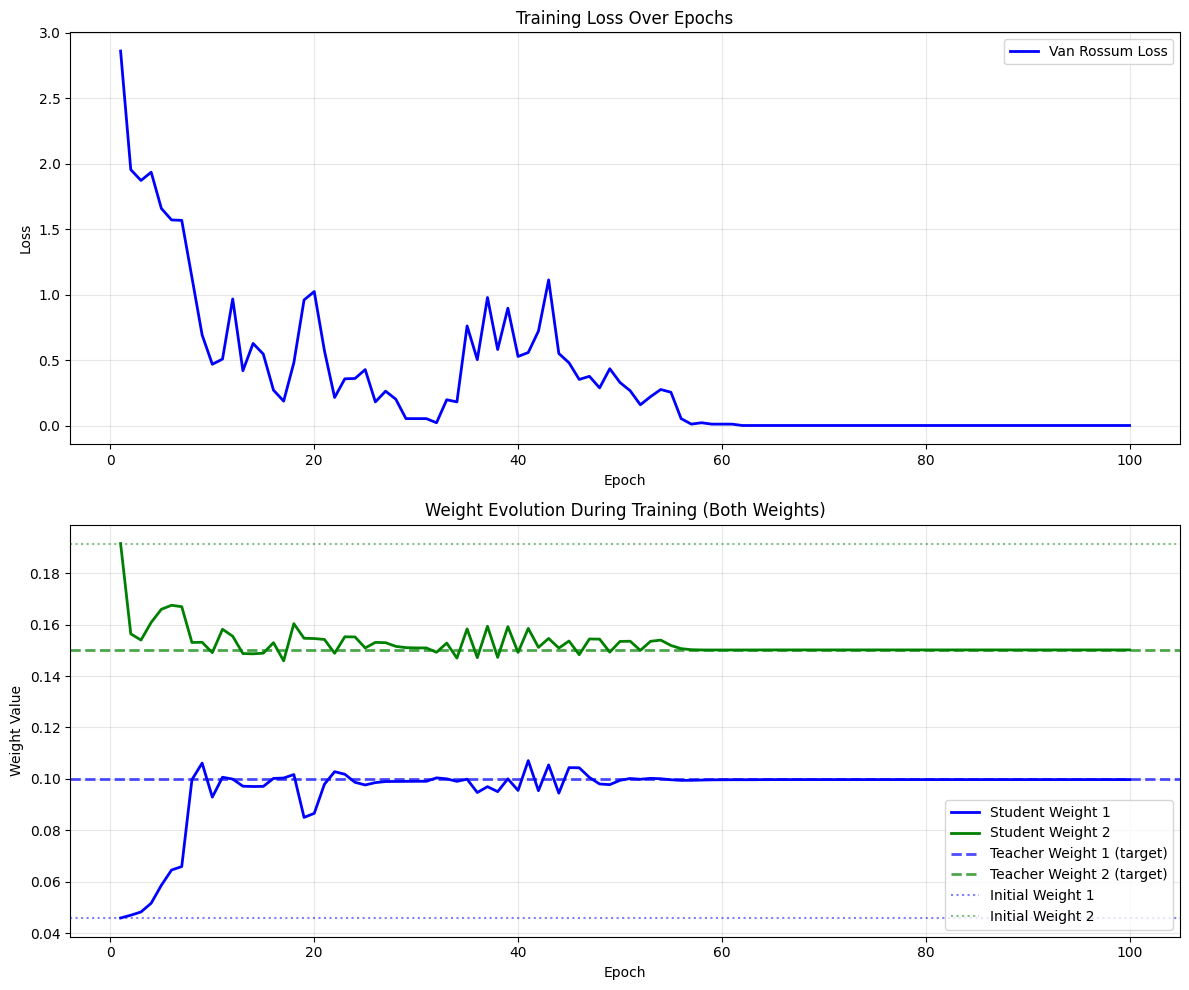


Training Summary:
Initial weights: [0.045856, 0.191556]
Final weights: [0.099714, 0.150171]
Target weights: [0.100000, 0.150000]

Weight errors:
  Weight 1: 0.000286
  Weight 2: 0.000171

Loss reduction: 100.0%
Initial loss: 2.858678
Final loss: 0.000000


In [12]:
# Plot loss and weight evolution
epoch_numbers = np.arange(1, epochs + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot total loss
ax1.plot(
    epoch_numbers,
    epoch_losses,
    label="Van Rossum Loss",
    linewidth=2,
    color="blue",
)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss Over Epochs")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot learned weights - both on same plot
ax2.plot(
    epoch_numbers,
    epoch_weights[:, 0],
    label="Student Weight 1",
    linewidth=2,
    color="blue",
)
ax2.plot(
    epoch_numbers,
    epoch_weights[:, 1],
    label="Student Weight 2",
    linewidth=2,
    color="green",
)

# Target lines
ax2.axhline(
    y=teacher_model.weights_FF.data[0, 0].item(),
    color="blue",
    linestyle="--",
    linewidth=2,
    label="Teacher Weight 1 (target)",
    alpha=0.7,
)
ax2.axhline(
    y=teacher_model.weights_FF.data[1, 0].item(),
    color="green",
    linestyle="--",
    linewidth=2,
    label="Teacher Weight 2 (target)",
    alpha=0.7,
)

# Initial weight lines
ax2.axhline(
    y=epoch_weights[0, 0],
    color="blue",
    linestyle=":",
    linewidth=1.5,
    label="Initial Weight 1",
    alpha=0.5,
)
ax2.axhline(
    y=epoch_weights[0, 1],
    color="green",
    linestyle=":",
    linewidth=1.5,
    label="Initial Weight 2",
    alpha=0.5,
)

ax2.set_xlabel("Epoch")
ax2.set_ylabel("Weight Value")
ax2.set_title("Weight Evolution During Training (Both Weights)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTraining Summary:")
print("=" * 60)
print(f"Initial weights: [{epoch_weights[0, 0]:.6f}, {epoch_weights[0, 1]:.6f}]")
print(f"Final weights: [{epoch_weights[-1, 0]:.6f}, {epoch_weights[-1, 1]:.6f}]")
print(
    f"Target weights: [{teacher_model.weights_FF.data[0, 0].item():.6f}, {teacher_model.weights_FF.data[1, 0].item():.6f}]"
)
print("\nWeight errors:")
print(
    f"  Weight 1: {abs(epoch_weights[-1, 0] - teacher_model.weights_FF.data[0, 0].item()):.6f}"
)
print(
    f"  Weight 2: {abs(epoch_weights[-1, 1] - teacher_model.weights_FF.data[1, 0].item()):.6f}"
)
print(
    f"\nLoss reduction: {((epoch_losses[0] - epoch_losses[-1]) / epoch_losses[0] * 100):.1f}%"
)
print(f"Initial loss: {epoch_losses[0]:.6f}")
print(f"Final loss: {epoch_losses[-1]:.6f}")